# Importation des librairies nécessaires

In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import pandas as pd
from requests import get
import numpy as np

import statsmodels.api as sm #librairie pour la regression

#librairies pour les graphique
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go

init_notebook_mode(connected=True)

# 1. Scraping des articles chaussures

## 1.1. Site "Running Conseil"

In [2]:
# l'URL de départ
url = "https://www.running-conseil.com/partenaires/mizuno?p=1"

#Création du dataframe contenant tous les articles du site "boutique marathon"
data = pd.DataFrame(columns={"names", "prices", "source"})
    
while True: # Faire une boucle pour défiler les pages et scrapper tous les articles
    
    response = get(url)
    html_soup = BeautifulSoup(response.text, 'html.parser')
    product_containers=html_soup.find_all("div",class_="item-wrap")

    prod_names, prices = [], []
    
    for container in product_containers:
        # Obtention des informations de chaque article
        prod_names.append(container.find("h2",{"class":"product-name"}).text)
        prices.append(container.find("span",{"class":"price"}).text.split(",")[0])
        
    #Ajout dans un nouveau dataframe
    new_data = pd.DataFrame({"names": prod_names, "prices": prices})

    #Indication de la source Running_conseil
    new_data["source"] = "running_conseil"

    data = data.append(new_data, sort=False)[new_data.columns.tolist()]
    
    # Une variable nous indiquant l'existence de la page suivante
    next_page_found = html_soup.select("a.next.i-next.icon-white")
    
    if next_page_found:
        url = url[:-1] + str(int(url[-1]) + 1)
    else:
        break

#On s'interesse seulement aux chaussures, on enleve donc les autres articles (les 46 premiers sont des chaussures, les autres non)
data = data.iloc[:47,]

#creation de la colonne is_male
data["is_male"] = data.apply(lambda row : 1 if "Homme" in row.loc["names"] else 0, axis=1)

Un premier aperçu des données donne :

In [3]:
data.head()

names prices           source  \
0    MIZUNO Wave Mujin 4 Homme Orange / Rouge / Noir    145  running_conseil   
1  MIZUNO WAVE MUJIN 5 Femme Ombre Blue/Silver/ H...    145  running_conseil   
2       MIZUNO Wave Mujin 4 Homme Noir / vert / Bleu    145  running_conseil   
3  MIZUNO WAVE DAICHI 3 Homme | Cherry Tomato/Est...    125  running_conseil   
4             MIZUNO Wave Horizon Homme Vert / Blanc    180  running_conseil   

   is_male  
0        1  
1        0  
2        1  
3        1  
4        1

## 1.2. Deuxieme site : le site officiel de "Mizuno"

In [4]:
# Lien du 2e site
url = "https://www.mizunoshop.fr/sports/running.html?categorie=223"

#Création du dataframe contenant tous les articles du site "boutique marathon"
data2 = pd.DataFrame(columns={"names", "prices", "tags", "source"})

#Supprimer le dernier élément et le remplacer par le chiffre de la boucle
response = get(url)

html_soup = BeautifulSoup(response.text, 'html.parser')

product_containers=html_soup.find_all("li",class_="item")

prod_names, prices, infos = [], [], []

for container in product_containers:
    # Obtention des informations de chaque article
    prod_names.append(container.h2.a.text)
    prices.append(container.find("span",{"class":"price"}).text.split("€")[0])
    infos.append(container.findAll('span')[2].text)

#Ajout dans un nouveau dataframe
data2 = pd.DataFrame({"names": prod_names, "prices": prices, "infos": infos})

#Indication de la source Mizuno
data2["source"] = "Mizuno"

#colonne male ou female
data2["is_male"] = data2.apply(lambda row : 1 if "Homme" in row.loc["infos"] else 0, axis=1)

Un apercu de la 2e base scrapée sur Mizuno donne : 

In [5]:
data2.head()

names prices                             infos  source  is_male
0    Wave Tenjin 3    250          Chaussures Running Homme  Mizuno        1
1  Wave Prophecy 7    160          Chaussures Running Homme  Mizuno        1
2  Wave Inspire 15    145          Chaussures Running Homme  Mizuno        1
3  Wave Inspire 15    145          Chaussures Running Homme  Mizuno        1
4     Wave Mujin 5    145  Chaussures Running & Trail Homme  Mizuno        1

## 1.3. Cross Referencing sur les deux sites

Il s'agit là de créer une table de données contenant uniquement les produits appartenant aux deux sites.

In [17]:
def cross_reference(title):
    """Cette fonction permet de retourner le tableau contenant la différence des prix entre les 2 sites
    
    Arguments:
        title {[str]} -- [nom de l'article à rechercher]
    
    Returns:
        [pandas dataframe] -- [description]
    """

    #Nouveau dataframe pour sélectionner les articles de la première base
    new_data = data[data.names == title].copy()
    
    #Vérifier l'apparition du titre recheché dans la 2e base de données
    appearances = [title in prod_name for prod_name in data2.names.values]
    
    #Sélectionner les articles où le titre apparait (tu peux printer pour voir les caractéristiques du même article sur les 2 sites :-))
    selected_references = new_data.append(data2[appearances], sort=False)[data2.columns.tolist()]
    #print(selected_references)

    #Dataframe final contenant la différence des prix
    final_data = pd.DataFrame()
    final_data["prod_name"] = [title]
    final_data["Difference_prix"] = [int(selected_references.head(1).prices.values[0]) - int(selected_references.tail(1).prices.values[0])]
    
    #Retouner le dataframe final
    return final_data

#Sélection de tous les noms d'article collectés sur le site "Mizuno"
titles = data2.names.values

#Création de la table de données
df = pd.DataFrame(columns={'prod_name', 'Difference_prix'})
for title in titles:
    df = df.append(cross_reference(title), sort=False)

### Sauvegarde des fichiers

In [18]:
df.to_csv("Cross_Reference_Data2.csv", sep=";", index=False)

In [21]:
df.drop_duplicates("prod_name").to_csv("Cross_Reference_Data3.csv", sep=";", index=False)

# 2. Regroupement des données

In [6]:
final_data = pd.concat([data, data2.drop("infos", axis=1)])

Nous affichons un échantillon aléatoire de la base finale

In [7]:
final_data.sample(5, random_state=23)

names prices           source  \
27        MIZUNO Wave Rider 21 - Homme - Bleu / Blanc    145  running_conseil   
0                                       Wave Tenjin 3    250           Mizuno   
21                                    Wave Inspire 14    100           Mizuno   
3   MIZUNO WAVE DAICHI 3 Homme | Cherry Tomato/Est...    125  running_conseil   
30                                         Wave Sonic     85           Mizuno   

    is_male  
27        1  
0         1  
21        0  
3         1  
30        0

# 3. Création des variables nécessaires à la régression

In [8]:
# Création de la variable "from_mizuno" qui prend 1 si l'article vient de mizuno et 0 sinon
final_data["from_mizuno"] = np.where(final_data.source == "Mizuno", 1, 0)

#select only relevent columns
final_data = final_data[["from_mizuno", "is_male", "prices"]]

# Modifier les prix en entier
final_data.prices = final_data.prices.astype(int)

#ajouter interaction des variables
final_data["mizuno_x_male"] = final_data.from_mizuno * final_data.is_male

# 4. Statistiques descriptives

## 4.1. Nombre d'articles par site

In [9]:
final_data.from_mizuno.value_counts().to_frame()

from_mizuno
0           47
1           44

Il y a en tout 91 articles dont 44 viennent du site "Mizuno".

## 4.2. Description des prix

In [10]:
final_data.prices.describe().to_frame().T

count        mean        std   min    25%    50%    75%    max
prices   91.0  128.912088  37.063504  30.0  102.5  135.0  145.0  250.0

La moyenne glogale des prix des chaussures mizuno sur les 2 sites est de 128,9 €.

# 5. Les graphiques

## 5.1. histogrammes superposés

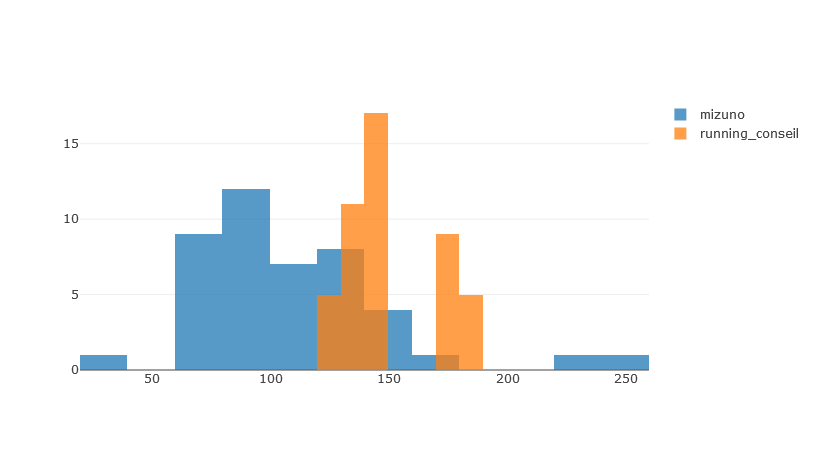

In [11]:
mizuno = go.Histogram(
    x=final_data.prices[final_data.from_mizuno == 1] ,
    opacity=0.75,
    name = 'mizuno'
)
running_conseil = go.Histogram(
    x=final_data.prices[final_data.from_mizuno == 0],
    opacity=0.75,
    name = 'running_conseil'
)

data3 = [mizuno, running_conseil]
layout = go.Layout(barmode='overlay')
fig = go.Figure(data=data3, layout=layout)

iplot(fig, filename='overlaid histogram')

## 5.2. Boxplot

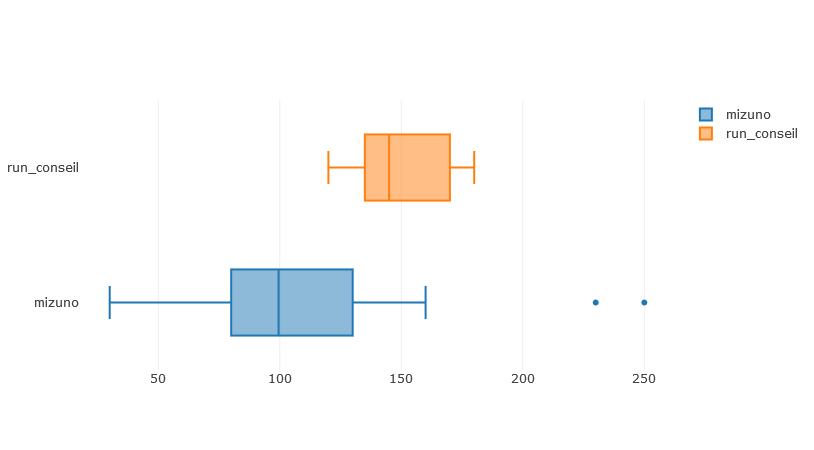

In [12]:
trace0 = go.Box(
    x=final_data.prices[final_data.from_mizuno == 1],
    name="mizuno"
)
trace1 = go.Box(
    x=final_data.prices[final_data.from_mizuno == 0],
    name="run_conseil"
)
data4 = [trace0, trace1]
iplot(data4)

## 5.3. Commentaires

A rédiger

# 6. Analyse économétrique : régression linéaire

## 6.1. Regression sans interaction

In [13]:
Y = final_data.prices
X = sm.add_constant(final_data[["from_mizuno", "is_male"]])
model = sm.OLS(endog=Y, exog=X)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 prices   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                     27.27
Date:                Sat, 23 Feb 2019   Prob (F-statistic):           6.09e-10
Time:                        13:17:06   Log-Likelihood:                -435.43
No. Observations:                  91   AIC:                             876.9
Df Residuals:                      88   BIC:                             884.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         137.6854      5.353     25.722      

## Commentaires

A rediger

## 6.2. Regression avec interaction

In [14]:
Y = final_data.prices
X = sm.add_constant(final_data[["from_mizuno", "is_male", "mizuno_x_male"]])
model = sm.OLS(endog=Y, exog=X)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 prices   R-squared:                       0.443
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     23.07
Date:                Sat, 23 Feb 2019   Prob (F-statistic):           4.43e-11
Time:                        13:17:06   Log-Likelihood:                -430.74
No. Observations:                  91   AIC:                             869.5
Df Residuals:                      87   BIC:                             879.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           146.5217      5.866     24.978

## Commentaires

A rediger

## 6.3 Modèles en logarithme

Dans les analyses économétriques, il très intéressant d'interpréter la variation du prix d'un bien en pourcenyage te non en valeur absolue. Pour cela, il faut efectuer un transformation logarithmique sur la variable prix (i.e. prix = Ln(prix)).

### 6.3.1. Sans interaction

In [15]:
Y = np.log(final_data.prices)
X = sm.add_constant(final_data[["from_mizuno", "is_male"]])
model = sm.OLS(endog=Y, exog=X)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 prices   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     30.13
Date:                Sat, 23 Feb 2019   Prob (F-statistic):           1.08e-10
Time:                        13:17:06   Log-Likelihood:                -3.1011
No. Observations:                  91   AIC:                             12.20
Df Residuals:                      88   BIC:                             19.73
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.9031      0.046    105.961      

### Commentaires

A rediger

### 6.3.2. Avec interaction

In [16]:
Y = np.log(final_data.prices)
X = sm.add_constant(final_data[["from_mizuno", "is_male", "mizuno_x_male"]])
model = sm.OLS(endog=Y, exog=X)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 prices   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.447
Method:                 Least Squares   F-statistic:                     25.26
Date:                Sat, 23 Feb 2019   Prob (F-statistic):           7.56e-12
Time:                        13:17:06   Log-Likelihood:                 1.6712
No. Observations:                  91   AIC:                             4.658
Df Residuals:                      87   BIC:                             14.70
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             4.9801      0.051     98.301

### Commentaires

A rediger